In [1]:
import numpy as np

from graphviz import Digraph
import networkx as nx
import networkx.algorithms as nxa
import re

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.system import LeapHybridSampler

import DeBruijnDNA
import AcyclicGraphDNA

import matplotlib.pyplot as plt

API_KEY = "D-WAVE_OCEAN_SDK_API_KEY" #API_KEY, register on https://www.dwavesys.com/take-leap

In [2]:
def solve_dwave(Q, API_KEY):
    """
    Q = np.array([[-1, 1, 0], [1, -1, -2], [0, -2, -1]])
    solve_dwave(Q)
    """
    q = {}
    size = len(Q)
    for i in range(size):
        for j in range(size):
            q[(i,j)] = Q[i][j]
            
    sampler = LeapHybridSampler(token=API_KEY)
    response = sampler.sample_qubo(q, num_reads=30, anneal_time=20)

    result = []
    for sample, energy in response.data(['sample', 'energy']): 
        result.append(sample)
        result.append(energy)

    result.append(response.info) # view timings
    
    return result

## 1. Hamiltonian path De Bruijn graph

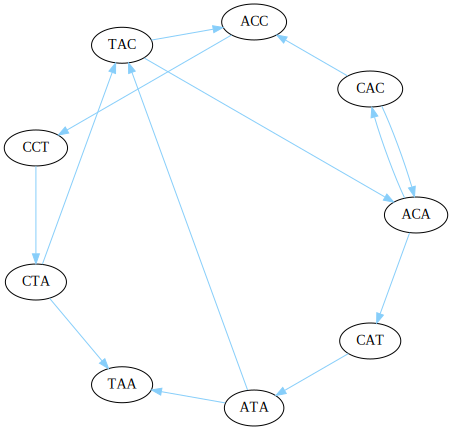

In [3]:
seq = 'CATACACCTAA'
kmer_len, suffix_len = 3, 2
adj, node_labels = DeBruijnDNA.make_debr(seq, kmer_len=kmer_len, suffix_len=suffix_len)

g, nodes = DeBruijnDNA.draw_graph(adj, node_labels, [], kmer_len = kmer_len)
g.engine = 'circo'
Q = DeBruijnDNA.to_qubo(adj)

g

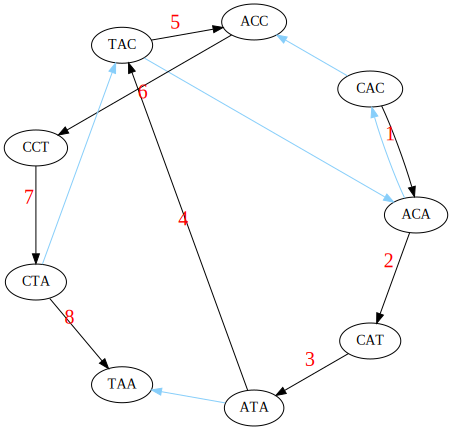

In [4]:
target_energy = -np.sqrt(len(Q))
solution = solve_dwave(Q, API_KEY=API_KEY)
spins, energy = [solution[0][i] for i in solution[0].keys()], solution[1]

g, nodes = DeBruijnDNA.draw_graph(adj, node_labels, path_spins=spins, kmer_len=kmer_len)
g.engine = 'circo'
g

## 2. Hamiltonian path in acyclic graph

### use spec for input gfa file: http://gfa-spec.github.io/GFA-spec/GFA1.html

In [5]:
filename = "phi-x.600l.gfa"
segments, links, containments = AcyclicGraphDNA.load_file(filename)

initial_graph, adjacency_matrix, nodes_indices, nodes_labels, links_edges = AcyclicGraphDNA.get_initial_graph(segments, links)
strand_graph = AcyclicGraphDNA.get_strand_graph(initial_graph)

print('links quantity: ', len(links_edges))

segments: 50, links: 248, containments: 0, lines: 299

nodes quantity: 100
links quantity:  496


strand_adjacency_matrix size: 50


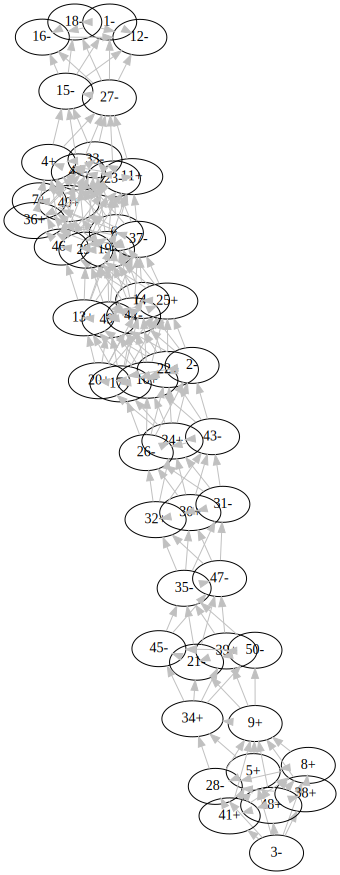

In [6]:
strand_graph_adjacency_matrix = nx.to_numpy_matrix(strand_graph)
print('strand_adjacency_matrix size:', len(strand_graph_adjacency_matrix))

edges = np.argwhere(strand_graph_adjacency_matrix==1).tolist()
nodes = list(strand_graph.nodes)
g = AcyclicGraphDNA.draw_graph(nodes, solve_edges=[], edges=edges)
g.engine = 'neato'

g

In [7]:
strand_graph_undirected = AcyclicGraphDNA.complement_to_undirected_graph(strand_graph)
adjacency_matrix = nx.to_numpy_matrix(strand_graph_undirected)
part_map, _ , _ = AcyclicGraphDNA.part_graph(cluster_number=3, adjacency_matrix=adjacency_matrix)

graphs = []
node_labels = list(strand_graph_undirected.nodes)
for part, nodes_indices in part_map.items():
    labels = [node_labels[i] for i in nodes_indices]
    graphs.append(strand_graph.subgraph(labels))

In [8]:
solve_edges=[]
for pg in graphs:
    adjacency_matrix = nx.to_numpy_matrix(pg)
    edges_indices = np.argwhere(adjacency_matrix==1).tolist()

    Q = AcyclicGraphDNA.to_qubo(adjacency_matrix)
    target_energy = -2.0*len(adjacency_matrix)+2
    solution = solve_dwave(Q, API_KEY=API_KEY)
    spins, energy = [solution[0][i] for i in solution[0].keys()], solution[1]

    solve_edges_idices=[]
    for i in range(len(spins)):
        if spins[i]==1:
            solve_edges_idices.append(edges_indices[i])

    node_labels = list(pg.nodes)
    solve_edges_part = [(node_labels[e[0]], node_labels[e[1]]) for e in solve_edges_idices]
    solve_edges+=solve_edges_part

In [9]:
g = AcyclicGraphDNA.draw_solution(graphs, strand_graph, strand_graph_undirected, part_map, solve_edges, show_all_edges=False)
g.engine = 'circo'
g